In [30]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import sims_pars as spr

In [37]:
prior = spr.bayes_net_from_script('''
    PCore cascade {
        r_succ_pub = 2
        rr_ltfu_pri = 1.5
        ppv_pub = 0.85
        ppv_eng = 0.85
        ppv_pri ~ unif(0.1, ppv_eng)
        
        p_pridrug ~ unif(0.2, 0.8)
        r_die_ut ~ unif(0.14, 0.18)
        r_sc ~ unif(0.1, 0.3)
        rr_die_asym ~ unif(0, 1)

        r_die_sym = r_die_ut
        r_die_asym = r_die_ut * rr_die_asym
        TxI_pri ~ unif(0.5, 1)

        dur_succ_pri ~ unif(0.5 / 12, 18 / 12)
        r_succ_pri = 1 / dur_succ_pri

        r_onset ~ unif(0.5, 3)
    }
    ''')

In [38]:
spr.sample(prior)

{'r_succ_pub': 2,
 'rr_ltfu_pri': 1.5,
 'ppv_pub': 0.85,
 'ppv_eng': 0.85,
 'p_pridrug': 0.6890269822078994,
 'r_die_ut': 0.1555175068724057,
 'r_sc': 0.11826583340236284,
 'rr_die_asym': 0.754361905771268,
 'TxI_pri': 0.8948107735665595,
 'dur_succ_pri': 0.7407138906867452,
 'r_onset': 1.39054948430402,
 'ppv_pri': 0.2813449579137708,
 'r_die_sym': 0.1555175068724057,
 'r_die_asym': 0.11731648286506424,
 'r_succ_pri': 1.350048935997218}

In [39]:
loc = 'India'

In [40]:
ds = pd.read_csv('../data/cascade/d_cascade_2019.csv').set_index('State')
ds = {i: row for i, row in ds.iterrows()}

In [41]:
d = ds[loc]
d.DrugMonth = 0.004350370
d

Region              India
N              1347720000
PrevUt           0.002907
PrevTx           0.001909
PrevTxPub        0.001313
PrevTxPri        0.000596
Pr_Pub_CSI       0.482818
Pr_Pub_CSI0      0.614003
Pr_Pub_CSI1      0.606058
Pr_Asym          0.630429
Pr_NotAware      0.212551
Pr_NotCS         0.031728
Pr_NotDet        0.125292
Pop            1357660000
CNR_pub           0.00127
CNR_eng            0.0005
TxI_pub              0.94
TxI_eng              0.95
TxSucc_pub       0.903226
TxSucc_eng       0.910256
TxDead_pub       0.043011
TxDead_eng       0.025641
TxLTFU_pub       0.053763
TxLTFU_eng       0.064103
Name: India, dtype: object

In [44]:
def solve1(pars, d):
    prev = d.PrevUt

    prev_a = prev * d.Pr_Asym
    prev_s = prev * d.Pr_NotAware
    prev_c = prev * d.Pr_NotCS
    prev_e = prev * d.Pr_NotDet

    r_die_asym, r_die_sym, r_sc = pars['r_die_asym'], pars['r_die_sym'], pars['r_sc']

    r_onset = pars['r_onset']

    mu = r_die_sym + r_sc
    r_aware = r_onset * prev_a / prev_s - mu
    r_csi = r_aware * prev_s / prev_c - mu
    r_det = r_csi * prev_c / prev_e - mu
    r_csi, r_det

    det = prev_e * r_det
    det_pub = d.CNR_pub * pars['ppv_pub']
    det_eng = d.CNR_eng * pars['ppv_eng']
    det_pri = det - det_pub - det_eng
    if det_pri < 0:
        raise ValueError()

    det_pri

    dur = d.PrevTxPri / (d.CNR_eng * d.TxI_eng + det_pri / pars['ppv_pri'] * pars['TxI_pri'])

    pridrug_eng = d.CNR_eng * d.TxI_eng * dur * pars['p_pridrug']
    pridrug_pri = det_pri / pars['ppv_pri'] * pars['TxI_pri'] * dur

    return {
        'dur_asym': 1 / (r_onset + r_die_asym + r_sc),
        'det_pri': det_pri,
        'ppv_pri': pars['ppv_pri'],
        'txi_pri': pars['TxI_pri'],
        'dur_pri': dur,
        'pridrug_eng': pridrug_eng,
        'pridrug_pri': pridrug_pri,
        'pdmo': (pridrug_eng + pridrug_pri) * 12
    }


In [45]:
ps = list()

while len(ps) < 1000:
    p = spr.sample(prior)
    try:
        p.update(solve1(p, d))
        ps.append(p)
    except ValueError:
        pass
    
ps = pd.DataFrame(ps)

In [46]:
ps.dur_asym.describe()

count    1000.000000
mean        0.465385
std         0.130170
min         0.296737
25%         0.354865
50%         0.426938
75%         0.548559
max         0.915988
Name: dur_asym, dtype: float64

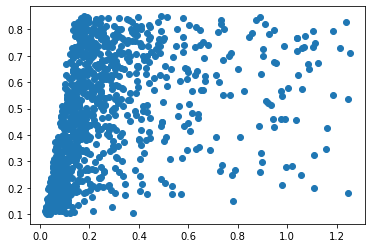

In [47]:
plt.scatter(ps.dur_pri, ps.ppv_pri)

In [48]:
ps.to_csv('../out/test.csv')

In [49]:
def solve2(pars, d):
    prev = d.PrevUt

    prev_a = prev * d.Pr_Asym
    prev_s = prev * d.Pr_NotAware
    prev_c = prev * d.Pr_NotCS
    prev_e = prev * d.Pr_NotDet

    r_die_asym, r_die_sym, r_sc = pars['r_die_asym'], pars['r_die_sym'], pars['r_sc']

    r_onset = pars['r_onset']

    mu = r_die_sym + r_sc
    r_aware = r_onset * prev_a / prev_s - mu
    r_csi = r_aware * prev_s / prev_c - mu
    r_det = r_csi * prev_c / prev_e - mu
    r_csi, r_det

    det = prev_e * r_det
    det_pub = d.CNR_pub * pars['ppv_pub']
    det_eng = d.CNR_eng * pars['ppv_eng']
    det_pri = det - det_pub - det_eng
    if det_pri < 0:
        raise ValueError()

    k1 = d.CNR_eng * d.TxI_eng
    k2 = det_pri * pars['TxI_pri']
    ppv = (k2 / k1) * (d.PrevTxPri - d.DrugMonth / 12) / (d.DrugMonth / 12 - d.PrevTxPri * pars['p_pridrug'])

    if ppv < 0 or ppv > 1:
        raise ValueError()
    dur = d.PrevTxPri / (d.CNR_eng * d.TxI_eng + det_pri / ppv * pars['TxI_pri'])

    pridrug_eng = d.CNR_eng * d.TxI_eng * dur * pars['p_pridrug']
    pridrug_pri = det_pri / ppv * pars['TxI_pri'] * dur
    
    return {
        'dur_asym': 1 / (r_onset + r_die_asym + r_sc),
        'det_pri': det_pri,
        'ppv_pri': ppv,
        'txi_pri': pars['TxI_pri'],
        'dur_pri': dur,
        'pridrug_eng': pridrug_eng,
        'pridrug_pri': pridrug_pri,
        'pdmo': (pridrug_eng + pridrug_pri) * 12
    }


In [53]:
ps = list()

while len(ps) < 1000:
    p = spr.sample(prior)
    try:
        p.update(solve2(p, d))
        ps.append(p)
    except ValueError:
        pass
    
ps = pd.DataFrame(ps)

In [54]:
ps

,r_succ_pub,rr_ltfu_pri,ppv_pub,ppv_eng,p_pridrug,r_die_ut,r_sc,rr_die_asym,TxI_pri,dur_succ_pri,...,r_die_sym,r_die_asym,r_succ_pri,dur_asym,det_pri,txi_pri,dur_pri,pridrug_eng,pridrug_pri,pdmo
0,2,1.5,0.85,0.85,0.285215,0.166229,0.171879,0.113992,0.838223,0.801055,...,0.166229,0.018949,1.248353,0.698194,0.000408,0.838223,0.687137,0.000093,0.000269,0.00435
1,2,1.5,0.85,0.85,0.244335,0.154340,0.239153,0.777116,0.946868,0.490081,...,0.154340,0.119940,2.040478,0.601818,0.000460,0.946868,0.649964,0.000075,0.000287,0.00435
2,2,1.5,0.85,0.85,0.507905,0.149536,0.170272,0.423176,0.621332,0.097132,...,0.149536,0.063280,10.295309,0.766759,0.000114,0.621332,0.998091,0.000241,0.000122,0.00435
3,2,1.5,0.85,0.85,0.305053,0.178359,0.132490,0.442622,0.915730,0.984990,...,0.178359,0.078945,1.015239,0.730567,0.000283,0.915730,0.706752,0.000102,0.000260,0.00435
4,2,1.5,0.85,0.85,0.208276,0.156915,0.123812,0.394954,0.762786,0.758383,...,0.156915,0.061974,1.318595,0.714885,0.000417,0.762786,0.620362,0.000061,0.000301,0.00435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2,1.5,0.85,0.85,0.331485,0.152833,0.262835,0.975875,0.817493,0.240681,...,0.152833,0.149146,4.154880,0.662747,0.000059,0.817493,0.734696,0.000116,0.000247,0.00435
996,2,1.5,0.85,0.85,0.433325,0.160291,0.233954,0.039777,0.788877,0.055805,...,0.160291,0.006376,17.919418,0.707548,0.000222,0.788877,0.866731,0.000178,0.000184,0.00435
997,2,1.5,0.85,0.85,0.388534,0.175546,0.184810,0.426293,0.813032,1.131604,...,0.175546,0.074834,0.883701,0.688057,0.000296,0.813032,0.803242,0.000148,0.000214,0.00435
998,2,1.5,0.85,0.85,0.310852,0.141090,0.143577,0.442443,0.537148,0.630717,...,0.141090,0.062424,1.585497,0.682267,0.000499,0.537148,0.712700,0.000105,0.000257,0.00435


In [56]:
ps.to_csv('../out/test2.csv')